# Imports

In [1]:
import numpy as np
import pandas as pd
import dowhy as dowhy
import dowhy.datasets, dowhy.plotter
from dowhy import gcm
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Define FAPS colours 
fapsgreen    = "#97C139"   # from (151,193,57)
fapsblue     = "#296193"   # from (41,97,147)
fapsdarkgray = "#5F5F5F"   # from (95,95,95)

# Set the random seed for reproducibility
np.random.seed(42)

## Load Dataset

In [2]:
df = pd.read_csv('./dataset.csv')

# Use only the designated columns
select_cols = []
select_cols.append('DXP_HoldingPressure1')
select_cols.append('E77_BarrelTemperatureZone6')
select_cols.append('E77_TransferStroke')
select_cols.append('E77_CushionVolume')
select_cols.append('E77_DosingTime')
select_cols.append('DXP_AreaCavityPressure')
select_cols.append('SCA_PartWeight')
select_cols.append('E77_CavityPressureMaximum')


# Meta columns
select_cols.append('MET_MachineCycleID')
select_cols.append('MET_MaterialName')

df = df[select_cols]

# Separate into materials
df = df[df['MET_MaterialName'] == 'PP']

df.drop(columns=['MET_MaterialName'], inplace=True)
df.drop(columns=['MET_MachineCycleID'], inplace=True)
df

,DXP_HoldingPressure1,E77_BarrelTemperatureZone6,E77_TransferStroke,E77_CushionVolume,E77_DosingTime,DXP_AreaCavityPressure,SCA_PartWeight,E77_CavityPressureMaximum
0,150.4,220.0,24.3045,10.29,10810.0,1840.3,97.56,89.0
1,150.4,220.0,24.3045,10.23,10810.0,1838.2,97.57,89.0
2,150.4,220.0,24.3045,10.38,10880.0,1783.4,97.52,85.0
3,150.4,220.0,24.3045,10.19,10970.0,1825.9,97.57,89.0
4,150.4,220.0,24.3045,10.38,10850.0,1775.2,97.50,85.0
...,...,...,...,...,...,...,...,...
298,150.0,262.0,27.8410,7.22,10890.0,3275.0,97.62,98.0
299,150.0,262.0,27.8410,7.23,10990.0,3234.9,97.57,98.0
300,149.9,262.0,27.8410,7.40,10970.0,3247.9,97.66,99.0
301,150.0,262.0,27.8410,7.40,11000.0,3285.7,97.69,99.0


# Normalize

In [3]:
# Min-max normalization
normalized_df = (df-df.min())/(df.max()-df.min())
norm_min = df.min()
norm_max = df.max()

df = normalized_df
df

,DXP_HoldingPressure1,E77_BarrelTemperatureZone6,E77_TransferStroke,E77_CushionVolume,E77_DosingTime,DXP_AreaCavityPressure,SCA_PartWeight,E77_CavityPressureMaximum
0,0.003318,0.000000,0.0,0.945260,0.304348,0.037940,0.123506,0.053571
1,0.003318,0.000000,0.0,0.937250,0.304348,0.037648,0.127490,0.053571
2,0.003318,0.000000,0.0,0.957276,0.365217,0.030015,0.107570,0.029762
3,0.003318,0.000000,0.0,0.931909,0.443478,0.035935,0.127490,0.053571
4,0.003318,0.000000,0.0,0.957276,0.339130,0.028873,0.099602,0.029762
...,...,...,...,...,...,...,...,...
298,0.000664,0.933333,1.0,0.535381,0.373913,0.237768,0.147410,0.107143
299,0.000664,0.933333,1.0,0.536716,0.460870,0.232182,0.127490,0.107143
300,0.000000,0.933333,1.0,0.559413,0.443478,0.233993,0.163347,0.113095
301,0.000664,0.933333,1.0,0.559413,0.469565,0.239258,0.175299,0.113095


# Generate DAGs

C:\Users\rejin\AppData\Local\Temp\ipykernel_20244\4032111460.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


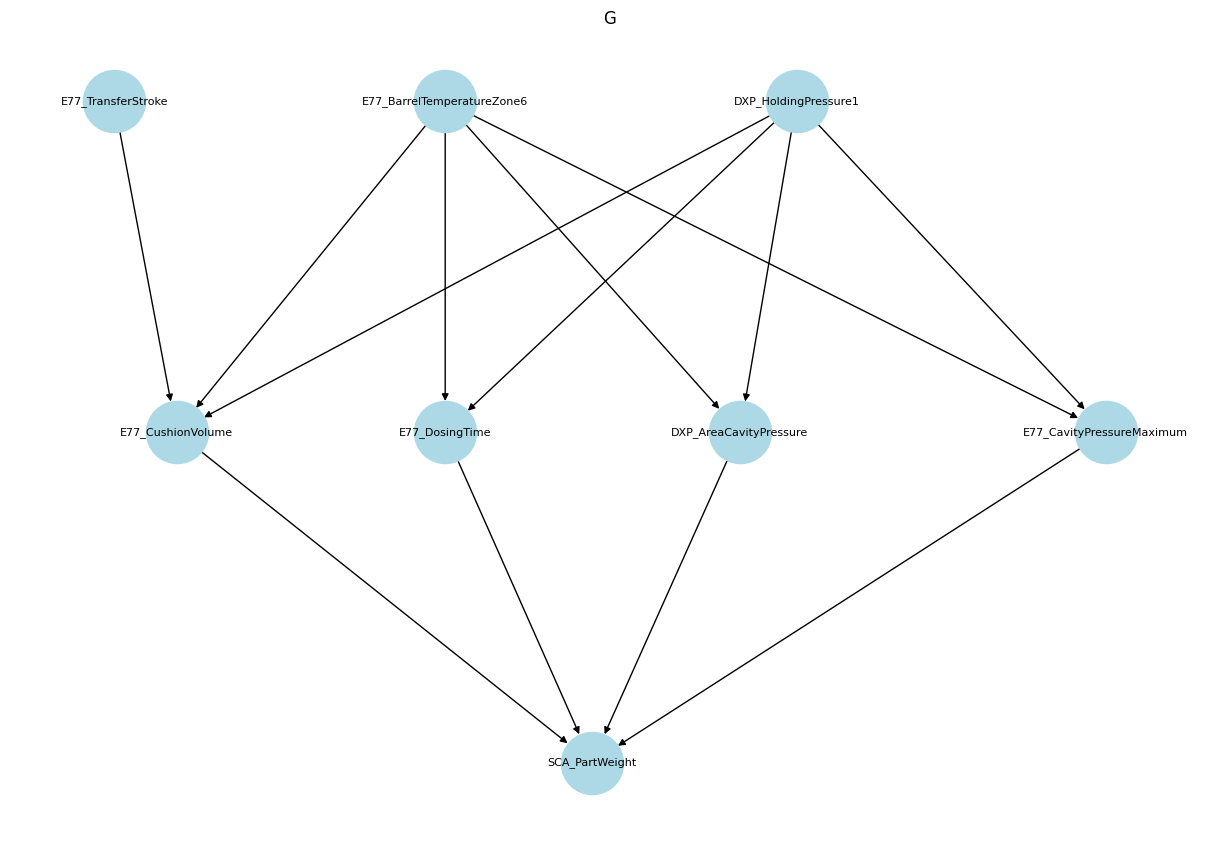

In [4]:
# Graph definition
graph_def_G = """
digraph {
    E77_DosingTime -> SCA_PartWeight;
    E77_CushionVolume -> SCA_PartWeight;
    DXP_AreaCavityPressure -> SCA_PartWeight;
    E77_CavityPressureMaximum -> SCA_PartWeight;
    DXP_HoldingPressure1 -> E77_DosingTime;
    E77_BarrelTemperatureZone6 -> E77_DosingTime;
    DXP_HoldingPressure1 -> E77_CushionVolume;
    E77_BarrelTemperatureZone6 -> E77_CushionVolume;
    E77_TransferStroke -> E77_CushionVolume;
    DXP_HoldingPressure1 -> E77_CavityPressureMaximum;
    E77_BarrelTemperatureZone6 -> E77_CavityPressureMaximum;
    DXP_HoldingPressure1 -> DXP_AreaCavityPressure;
    E77_BarrelTemperatureZone6 -> DXP_AreaCavityPressure;
}
"""

# Create the NetworkX graph from the graph definition
(graph,) = pydot.graph_from_dot_data(graph_def_G)
G = nx.DiGraph(nx.drawing.nx_pydot.from_pydot(graph))

# Visualize the main graph and subgraphs
pos = graphviz_layout(G, prog='dot')
plt.figure(figsize=(12, 8))

# Draw the main graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8, arrows=True)
plt.title("G")

plt.tight_layout()
plt.show()

In [5]:
# Define the Structural Hamming Distance function
def shd(G_org, G_mod):
    edges1 = set(G_org.edges())
    edges2 = set(G_mod.edges())
    distance = len(edges1.symmetric_difference(edges2))
    print(f"Structural Hamming Distance between expert-derived and modified combined graphs: {distance}")

C:\Users\rejin\AppData\Local\Temp\ipykernel_20244\933459226.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


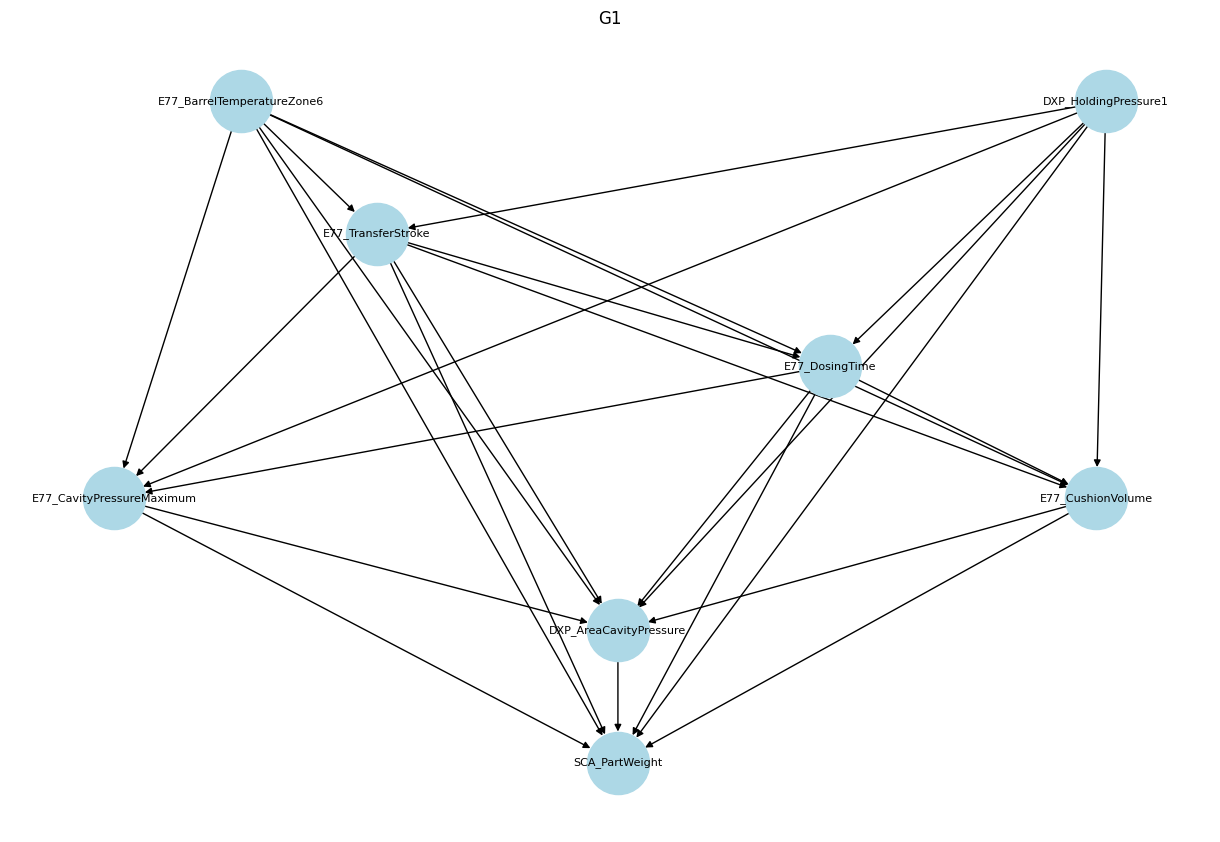

Structural Hamming Distance between expert-derived and modified combined graphs: 13


In [6]:
# Graph definition
graph_def_G1 = """
digraph {
    E77_BarrelTemperatureZone6 -> E77_TransferStroke;
    DXP_HoldingPressure1 -> E77_TransferStroke;
    E77_DosingTime -> E77_CushionVolume;
    E77_DosingTime -> E77_CavityPressureMaximum;
    E77_DosingTime -> DXP_AreaCavityPressure;
    E77_CushionVolume -> DXP_AreaCavityPressure;
    E77_CavityPressureMaximum -> DXP_AreaCavityPressure;
    E77_TransferStroke -> E77_CushionVolume;
    E77_TransferStroke -> E77_CavityPressureMaximum;
    E77_TransferStroke -> DXP_AreaCavityPressure;
    E77_TransferStroke -> E77_DosingTime;
    E77_BarrelTemperatureZone6 -> E77_CushionVolume;
    E77_BarrelTemperatureZone6 -> E77_CavityPressureMaximum;
    E77_BarrelTemperatureZone6 -> DXP_AreaCavityPressure;
    E77_BarrelTemperatureZone6 -> E77_DosingTime;
    DXP_HoldingPressure1 -> E77_CushionVolume;
    DXP_HoldingPressure1 -> E77_CavityPressureMaximum;
    DXP_HoldingPressure1 -> DXP_AreaCavityPressure;
    DXP_HoldingPressure1 -> E77_DosingTime;
    E77_TransferStroke -> SCA_PartWeight;
    E77_DosingTime -> SCA_PartWeight;
    E77_CushionVolume -> SCA_PartWeight;
    DXP_AreaCavityPressure -> SCA_PartWeight;
    E77_CavityPressureMaximum -> SCA_PartWeight;
    DXP_HoldingPressure1 -> SCA_PartWeight;
    E77_BarrelTemperatureZone6 -> SCA_PartWeight;
}
"""
# Create the NetworkX graph from the graph definition
(graph,) = pydot.graph_from_dot_data(graph_def_G1)
G1 = nx.DiGraph(nx.drawing.nx_pydot.from_pydot(graph))

# Visualize the main graph and subgraphs
pos = graphviz_layout(G1, prog='dot')
plt.figure(figsize=(12, 8))

# Draw the main graph
nx.draw(G1, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8, arrows=True)
plt.title("G1")

plt.tight_layout()
plt.show()
shd(G, G1)

C:\Users\rejin\AppData\Local\Temp\ipykernel_20244\1508991934.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


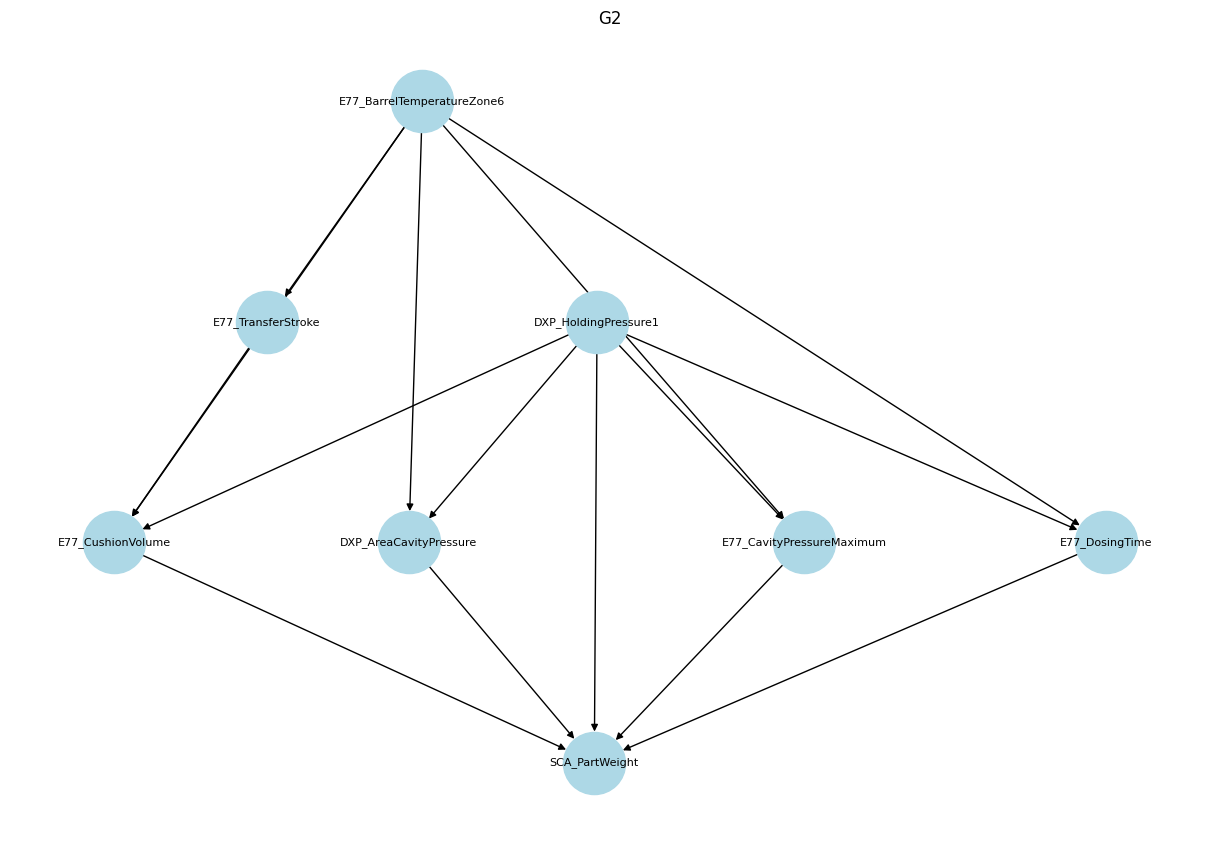

Structural Hamming Distance between expert-derived and modified combined graphs: 2


In [7]:
# Graph definition
graph_def_G2 ="""
digraph {
    E77_DosingTime -> SCA_PartWeight;
    E77_CushionVolume -> SCA_PartWeight;
    DXP_AreaCavityPressure -> SCA_PartWeight;
    E77_CavityPressureMaximum -> SCA_PartWeight;
    DXP_HoldingPressure1 -> E77_DosingTime;
    E77_BarrelTemperatureZone6 -> E77_DosingTime;
    DXP_HoldingPressure1 -> E77_CushionVolume;
    E77_BarrelTemperatureZone6 -> E77_CushionVolume;
    E77_TransferStroke -> E77_CushionVolume;
    DXP_HoldingPressure1 -> E77_CavityPressureMaximum;
    E77_BarrelTemperatureZone6 -> E77_CavityPressureMaximum;
    DXP_HoldingPressure1 -> DXP_AreaCavityPressure;
    E77_BarrelTemperatureZone6 -> DXP_AreaCavityPressure;
    E77_BarrelTemperatureZone6 -> E77_TransferStroke
    DXP_HoldingPressure1 -> SCA_PartWeight
}
"""

# Create the NetworkX graph from the graph definition
(graph,) = pydot.graph_from_dot_data(graph_def_G2)
G2 = nx.DiGraph(nx.drawing.nx_pydot.from_pydot(graph))

# Visualize the graph
pos = graphviz_layout(G2, prog='dot')
plt.figure(figsize=(12, 8))

# Draw the graph
nx.draw(G2, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8, arrows=True)
plt.title("G2")
plt.tight_layout()
plt.show()
shd(G, G2)

# Create Model

In [8]:
# Function to create causal models for individual treatments
def create_individual_models(df, graph_def, treatment_vars):
    models = {}
    for treatment in treatment_vars:
        model = dowhy.CausalModel(
            data=df,
            graph=graph_def,
            treatment=treatment,
            outcome='SCA_PartWeight'
        )
        models[treatment] = model
    return models

In [9]:
# List of treatment variables
treatment_vars = [
    'E77_CushionVolume',
    'E77_DosingTime',
    'DXP_AreaCavityPressure',
    'E77_CavityPressureMaximum'
]

In [10]:
# Create individual models for each graph
models_G = create_individual_models(df, graph_def_G, treatment_vars)
models_G1 = create_individual_models(df, graph_def_G1, treatment_vars)
models_G2 = create_individual_models(df, graph_def_G2, treatment_vars)

# Identify & Calculate Estimand

In [11]:
# Function to estimate effects for a set of models and store identified_estimand and estimates
def estimate_effects(models):
    effects = {}
    identified_estimands = {}
    estimates = {}
    for treatment, model in models.items():
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            warnings.filterwarnings("ignore", category=FutureWarning)
            
            identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
            estimate = model.estimate_effect(
                identified_estimand,
                method_name="backdoor.linear_regression",
                test_significance=True
            )
        
        effects[treatment] = {
            'Estimated Effect': estimate.value,
            'P-value': estimate.test_stat_significance()['p_value']
        }
        identified_estimands[treatment] = identified_estimand
        estimates[treatment] = estimate
    return effects, identified_estimands, estimates

In [12]:
# Estimate effects for each graph
effects_G, identified_estimands_G, estimates_G = estimate_effects(models_G)
effects_G1, identified_estimands_G1, estimates_G1 = estimate_effects(models_G1)
effects_G2, identified_estimands_G2, estimates_G2 = estimate_effects(models_G2)

In [13]:
# Create DataFrames for each graph
def create_graph_df(effects, graph_name):
    return pd.DataFrame([
        {
            'Graph': graph_name,
            'Treatment': treatment,
            'Estimated Effect': data['Estimated Effect'],
            'P-value': data['P-value']
        }
        for treatment, data in effects.items()
    ])

df_G = create_graph_df(effects_G, 'G')
df_G1 = create_graph_df(effects_G1, 'G1')
df_G2 = create_graph_df(effects_G2, 'G2')

In [14]:
# Combine all results
df_combined = pd.concat([df_G, df_G1, df_G2])

# Sort values and rearrange columns
df_combined = df_combined.sort_values(
    ['Treatment', 'Estimated Effect'], 
    ascending=[True, False]
).reset_index(drop=True)[['Treatment', 'Graph', 'Estimated Effect', 'P-value']]

df_combined

,Treatment,Graph,Estimated Effect,P-value
0,DXP_AreaCavityPressure,G,-0.308382,[3.5819404702227647e-31]
1,DXP_AreaCavityPressure,G2,-0.308382,[3.5819404702227647e-31]
2,DXP_AreaCavityPressure,G1,-0.453307,[3.6165435231278888e-65]
3,E77_CavityPressureMaximum,G,0.959156,[2.468224048448236e-16]
4,E77_CavityPressureMaximum,G2,0.959156,[2.468224048448236e-16]
5,E77_CavityPressureMaximum,G1,-0.364450,[5.672805556543304e-06]
6,E77_CushionVolume,G1,-0.941726,[1.2709207949884507e-30]
7,E77_CushionVolume,G,-0.986497,[1.431673158000872e-24]
8,E77_CushionVolume,G2,-0.986497,[1.431673158000872e-24]
9,E77_DosingTime,G1,0.401798,[6.152880615740513e-58]


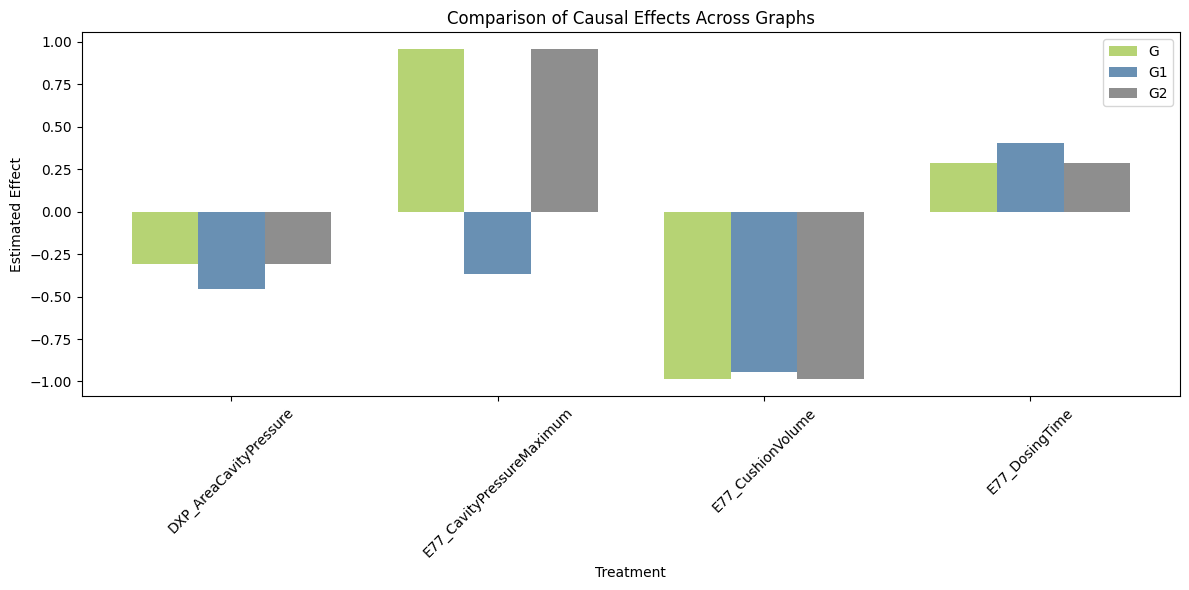

In [15]:
# Create visualization
plt.figure(figsize=(12, 6))
treatments = df_combined['Treatment'].unique()
x = np.arange(len(treatments))
width = 0.25

# Pivot the data for plotting
df_pivot = df_combined.pivot(index='Treatment', columns='Graph', values='Estimated Effect').reindex(treatments)

plt.bar(x - width, df_pivot['G'], width, label='G', color=fapsgreen, alpha=0.7)
plt.bar(x, df_pivot['G1'], width, label='G1', color=fapsblue, alpha=0.7)
plt.bar(x + width, df_pivot['G2'], width, label='G2', color=fapsdarkgray, alpha=0.7)

plt.xlabel('Treatment')
plt.ylabel('Estimated Effect')
plt.title('Comparison of Causal Effects Across Graphs')
plt.xticks(x, treatments, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()